In [1]:
import os, pandas as pd, numpy as np, matplotlib.pyplot as plt
import scanpy, networkx, scprep, magic, phate, scipy, DiffusionEMD, pygsp, torch, sklearn
import rpy2, rpy2.situation, anndata2ri
from localization import * #Wavelet module

2023-04-19 10:34:26.889487: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print(os.getcwd())
data_dir = f"{os.getcwd()}/data"
kge_dir = f"{os.getcwd()}/KGEs"

/var/home/ferran/PhD/yaleCollab


Notebook to compute and compare cellular distances on 3 different spaces:

- Gene expression of WT organoid + fibroblast co-culture
- Dataset projection on customLRT KGE
- Dataset projection on omnipath KGE

# Data ingestion

## scRNAseq data

In [3]:
for i in rpy2.situation.iter_info(): # Print Rpy2 info
    print(i)

rpy2 version:
3.5.11
Python version:
3.9.16 | packaged by conda-forge | (main, Feb  1 2023, 21:39:03) 
[GCC 11.3.0]
Looking for R's HOME:
    Environment variable R_HOME: /var/home/ferran/miniconda3/envs/collab/lib/R
    Calling `R RHOME`: /var/home/ferran/miniconda3/envs/collab/lib/R
    Environment variable R_LIBS_USER: None
R's additions to LD_LIBRARY_PATH:

R version:
    In the PATH: R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
    Loading R library from rpy2: OK
Additional directories to load R packages from:
None
C extension compilation:
  include:
  ['/var/home/ferran/miniconda3/envs/collab/lib/R/include']
  libraries:
  ['R', 'pcre2-8', 'lzma', 'bz2', 'z', 'rt', 'dl', 'm', 'iconv', 'icuuc', 'icui18n']
  library_dirs:
  ['/var/home/ferran/miniconda3/envs/collab/lib', '/var/home/ferran/miniconda3/envs/collab/lib/R/lib', '/var/home/ferran/miniconda3/envs/collab/lib']
  extra_compile_args:
  ['-std=c99']
  extra_link_args:
  ['-Wl,--export-dynamic', '-fopenmp', '-Wl,-O2', '-

In [4]:
anndata2ri.activate() #This HAS TO be run b4 loading the rpy2 extension
%load_ext rpy2.ipython

In [7]:
%%R -i data_dir -o dRnaSeq,dPHATEcoord
library(tidyverse)
library(Seurat)

d_fibWT = readRDS(paste0(data_dir,"/Omics/","d_fibWT.rds"))
d_fibWT@active.assay <- "RNA" #Ensure RNA is default assay
print(d_fibWT)
#Convert seurat object to anndata
dRnaSeq = as.SingleCellExperiment(d_fibWT)
#Export PHATE coordinates
dPHATEcoord = as.data.frame(Embeddings(d_fibWT, reduction = "phate"))

rm(d_fibWT)

An object of class Seurat 
40940 features across 3698 samples within 2 assays 
Active assay: RNA (20867 features, 10000 variable features)
 1 other assay present: SCT
 3 dimensional reductions calculated: pca, umap, phate


AxisArrays with keys: 
Before filtering we have 20867 genes


/var/home/ferran/miniconda3/envs/collab/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


After filtering genes expressed in fewer than 4 cells we have 20666


AnnData object with n_obs × n_vars = 3698 × 20666
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'mito_content', 'rfp_content', 'gfp_content', 'nCount_SCT', 'nFeature_SCT', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'CCDiff', 'SCT_snn_res.0.6', 'seurat_clusters', 'curatedCLUST', 'old.clust', 'finalPOPS', 'ident'
    var: 'n_cells'
    obsm: 'X_PHATE'
    layers: 'logcounts'

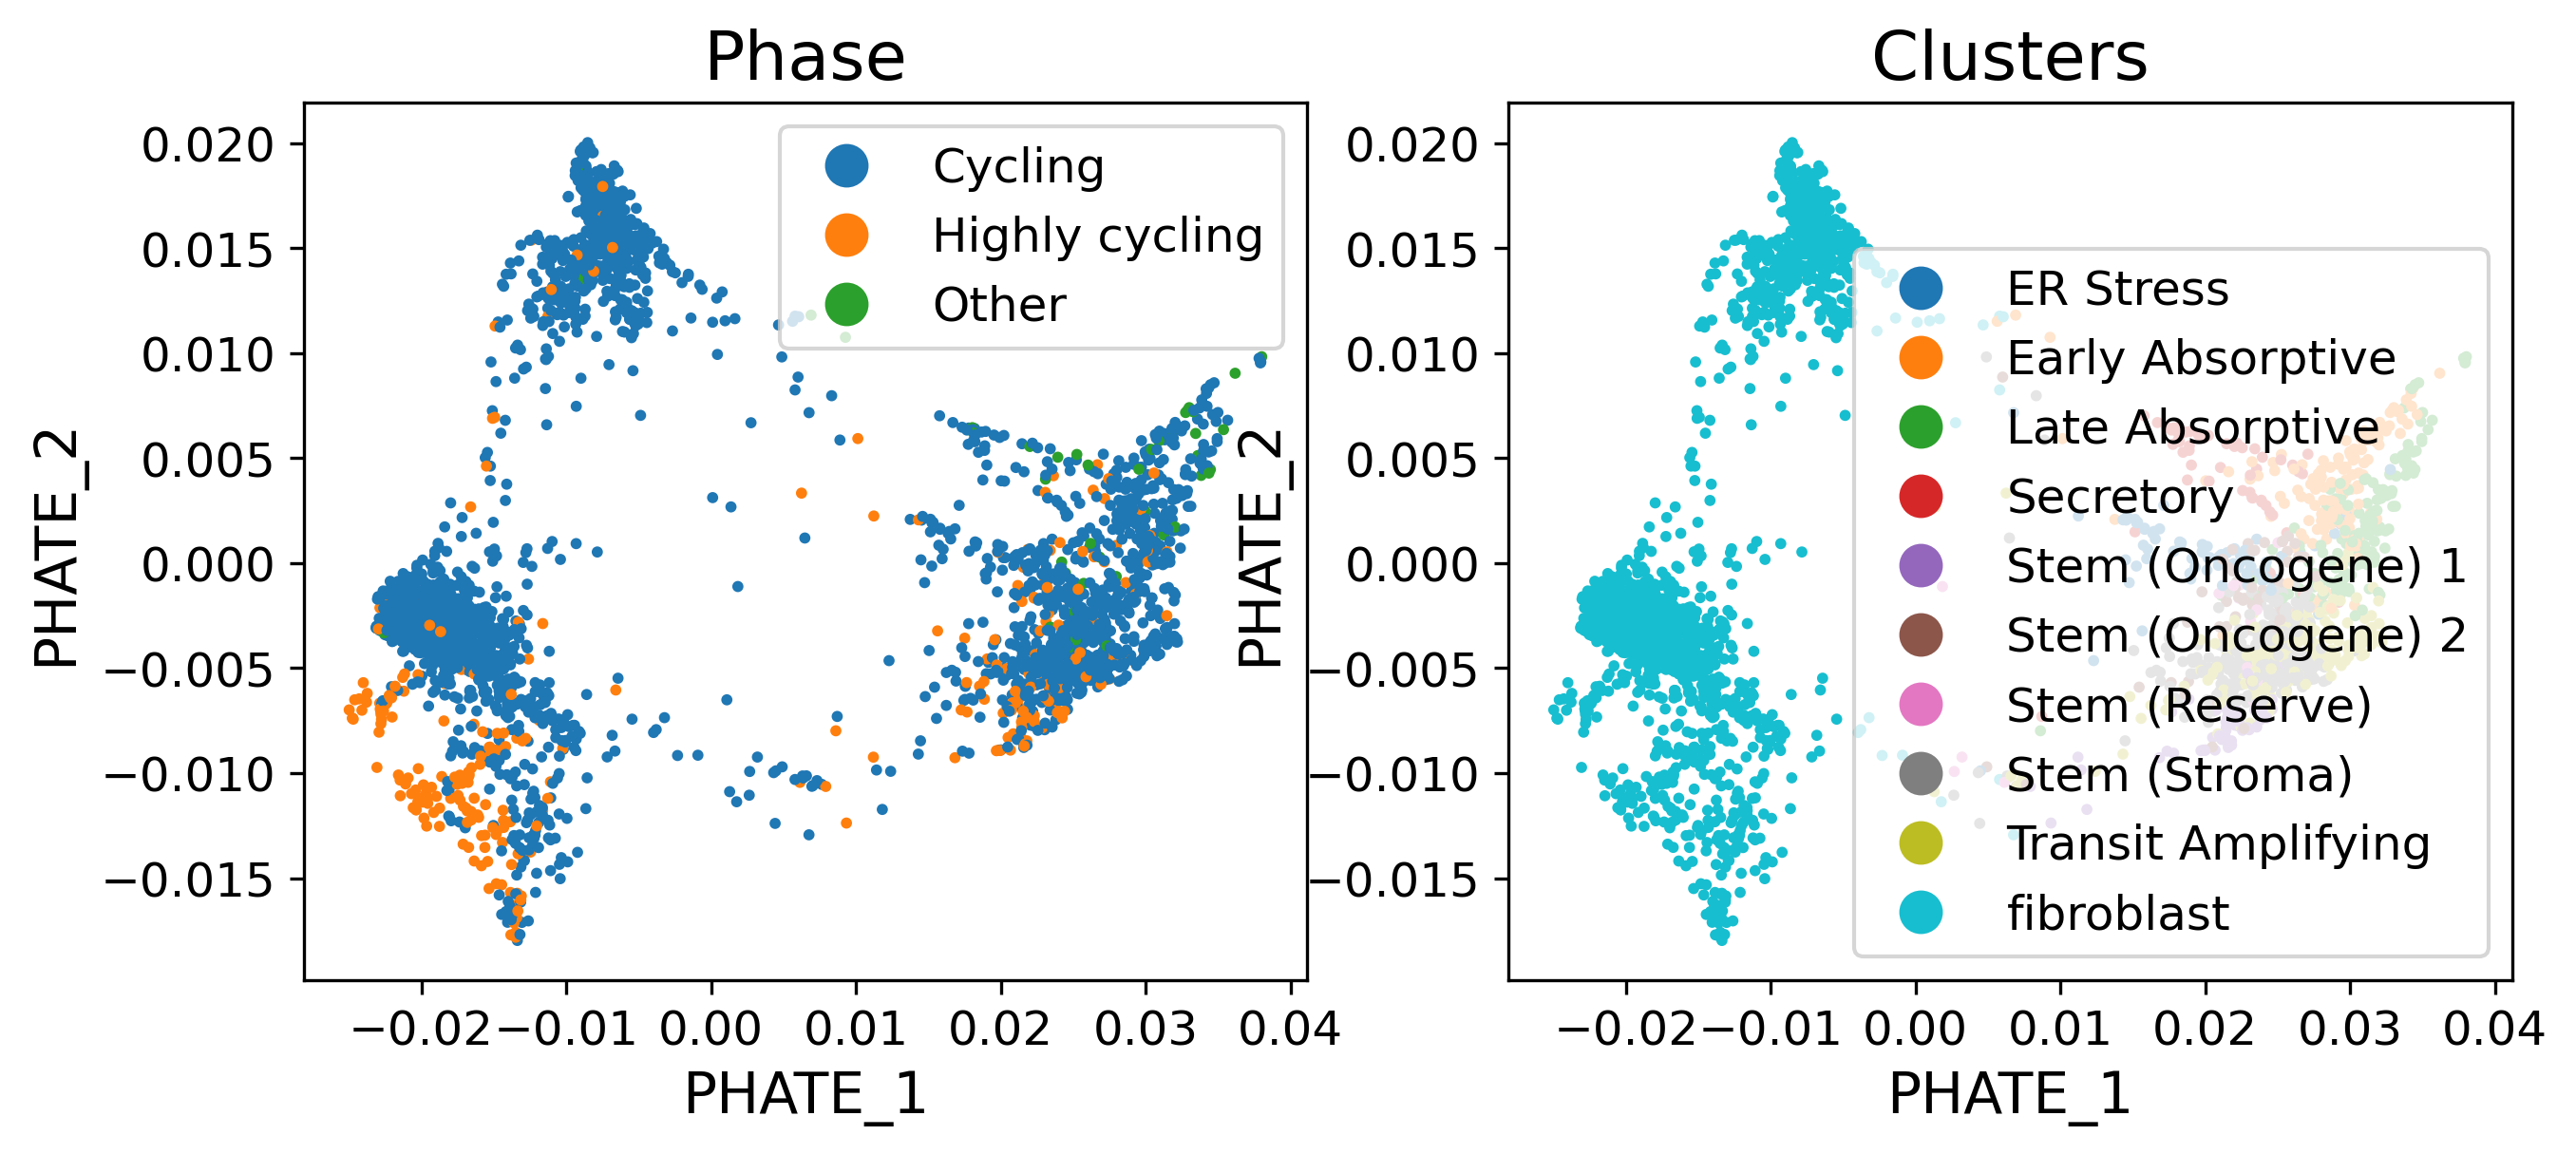

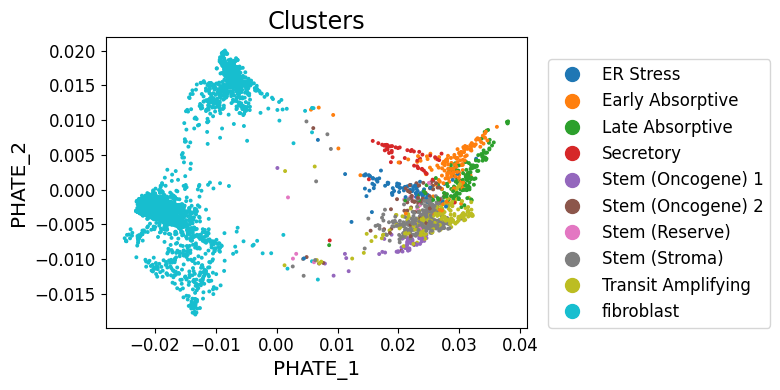

In [8]:
print(dRnaSeq.obsm)#No DimRed were ported over
#Add phate dims and view
dRnaSeq.obsm["X_PHATE"] = dPHATEcoord
del dPHATEcoord


fig, ax = plt.subplots(1,2, figsize=(10,4), dpi=300); ax=ax.flatten()
scprep.plot.scatter2d(dRnaSeq.obsm["X_PHATE"], c=dRnaSeq.obs.Phase, figsize=(4.8,3),
    title=f"Phase", ax=ax[0])
scprep.plot.scatter2d(dRnaSeq.obsm["X_PHATE"], c=dRnaSeq.obs.finalPOPS, figsize=(4.8,3),
    title=f"Clusters", ax=ax[1])

scprep.plot.scatter2d(
    dRnaSeq.obsm["X_PHATE"], 
    c=dRnaSeq.obs.finalPOPS, 
    title=f"Clusters", 
    legend_loc=(1.05, 0), shuffle=True,
    figsize=(8,4), dpi=480)

print(f"Before filtering we have {len(dRnaSeq.var_names)} genes")
scanpy.pp.filter_genes(dRnaSeq, min_cells=4, inplace=True)
print(f"After filtering genes expressed in fewer than 4 cells we have {len(dRnaSeq.var_names)}")

dRnaSeq

### Process data to human
Convert SEQ data to HGNC symbols

In [9]:
from biomart import BiomartServer

mart = BiomartServer("http://www.ensembl.org/biomart").datasets["mmusculus_gene_ensembl"]
# mart.show_attributes()
# for i in mart.show_attributes_by_page():
#     print(i)

response = mart.search({"attributes":["external_gene_name",
            "hsapiens_homolog_associated_gene_name"]})

mouse2human = []
for line in response.raw.data.decode("utf-8").splitlines():
    line = line.split("\t")
    if len(line[0]) > 0: #Only get gene symbols with ENSP ID
        mouse2human.append(line)
mouse2human = pd.DataFrame(mouse2human, 
                columns=["mgi_symbol","hgnc_symbol"]
                ).drop_duplicates() 
mouse2human = mouse2human.set_index("mgi_symbol"
                ).to_dict(
                    #Transform DF into a dictionary but first set index
                )["hgnc_symbol"]#Nested dict, so get first (and only item)


In [10]:
dSEQmd = dRnaSeq.obs
dRnaSeq = dRnaSeq.to_df(layer="logcounts").rename(columns=mouse2human).drop(
            columns=[""])
#After conversion some columns get duplicated. Group by them and average their gene expression
dRnaSeq = dRnaSeq.groupby(by=dRnaSeq.columns, axis=1).mean()
dRnaSeq

,0610010F05Rik,1110008P14Rik,1110012L19Rik,1110051M20Rik,1300017J02Rik,1500009C09Rik,1700007K13Rik,1700012D14Rik,1700013F07Rik,1700015F17Rik,...,ZZEF1,ZZZ3,Zbed5,Zfp91.1,Zkscan7.1,Znrd1,Znrd1as,n-R5-8s1,pEGFP,partDsRedE
WT__AAACCCACAGCTTCCT-1,0.0,1.050319,0.000000,0.000000,0.0,0.0,0.0,0.657148,0.0,0.0,...,0.657148,0.657148,0.000000,0.000000,0.0,1.050319,0.657148,0.0,0.0,0.657148
WT__AAACCCAGTTCGAGCC-1,0.0,0.498218,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.829238,0.498218,0.000000,0.0,1.077511,0.000000,0.0,0.0,0.000000
WT__AAACGAAAGAAGGATG-1,0.0,1.222830,0.000000,0.469502,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
WT__AAACGAAAGGAAAGGT-1,0.0,1.006978,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,1.006978,0.0,0.000000,0.000000,0.0,0.0,0.000000
WT__AAACGAAAGTTAACGA-1,0.0,1.497693,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.221506,0.000000,0.000000,0.221506,0.0,0.556103,0.221506,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WT__TTTGGTTTCATTCTTG-1,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.695505,0.0,0.000000,0.000000,0.0,0.0,0.000000
WT__TTTGGTTTCCGTAGTA-1,0.0,0.494771,0.000000,0.494771,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,1.071710,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.494771
WT__TTTGTTGTCGCTTGAA-1,0.0,0.461624,0.461624,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
WT__TTTGTTGTCTGAATCG-1,0.0,1.184048,0.882624,0.249549,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.882624,0.000000,0.0,0.0,0.000000


### Pre-processing: MAGIC

Use MAGIC with all genes to denoise, smooth and inpute missing values.
Return only genes in KG.

In [11]:
# magic_op = magic.MAGIC(
#     knn=5, # knn_max set to 3*knn by default
#     knn_dist="euclidean",
#     decay=1, t=3, n_pca=100, random_state=12,
#     n_jobs=-2 #All but one
#                         )

# dMagicRnaSeq = magic_op.fit_transform(
#     X = dRnaSeq,
#     genes = dRnaSeq.columns[dRnaSeq.columns.isin(entityIDS.values())]
# )
# del magic_op,dRnaSeq
# dMagicRnaSeq

In [12]:
dRnaSeq

,0610010F05Rik,1110008P14Rik,1110012L19Rik,1110051M20Rik,1300017J02Rik,1500009C09Rik,1700007K13Rik,1700012D14Rik,1700013F07Rik,1700015F17Rik,...,ZZEF1,ZZZ3,Zbed5,Zfp91.1,Zkscan7.1,Znrd1,Znrd1as,n-R5-8s1,pEGFP,partDsRedE
WT__AAACCCACAGCTTCCT-1,0.0,1.050319,0.000000,0.000000,0.0,0.0,0.0,0.657148,0.0,0.0,...,0.657148,0.657148,0.000000,0.000000,0.0,1.050319,0.657148,0.0,0.0,0.657148
WT__AAACCCAGTTCGAGCC-1,0.0,0.498218,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.829238,0.498218,0.000000,0.0,1.077511,0.000000,0.0,0.0,0.000000
WT__AAACGAAAGAAGGATG-1,0.0,1.222830,0.000000,0.469502,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
WT__AAACGAAAGGAAAGGT-1,0.0,1.006978,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,1.006978,0.0,0.000000,0.000000,0.0,0.0,0.000000
WT__AAACGAAAGTTAACGA-1,0.0,1.497693,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.221506,0.000000,0.000000,0.221506,0.0,0.556103,0.221506,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WT__TTTGGTTTCATTCTTG-1,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.695505,0.0,0.000000,0.000000,0.0,0.0,0.000000
WT__TTTGGTTTCCGTAGTA-1,0.0,0.494771,0.000000,0.494771,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,1.071710,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.494771
WT__TTTGTTGTCGCTTGAA-1,0.0,0.461624,0.461624,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
WT__TTTGTTGTCTGAATCG-1,0.0,1.184048,0.882624,0.249549,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.882624,0.000000,0.0,0.0,0.000000


Calculating PHATE...
  Running PHATE on 3698 observations and 13794 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 5.80 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.32 seconds.
    Calculating affinities...
    Calculated affinities in 0.04 seconds.
  Calculated graph and diffusion operator in 6.25 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.18 seconds.
    Calculating KMeans...
    Calculated KMeans in 3.29 seconds.
  Calculated landmark operator in 4.22 seconds.
  Calculating optimal t...
    Automatically selected t = 21
  Calculated optimal t in 2.07 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.59 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 4.73 seconds.
Calculated PHATE in 17.87 seconds.


/var/home/ferran/miniconda3/envs/collab/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Axes: title={'center': 'Logcounts (col=clust)'}>

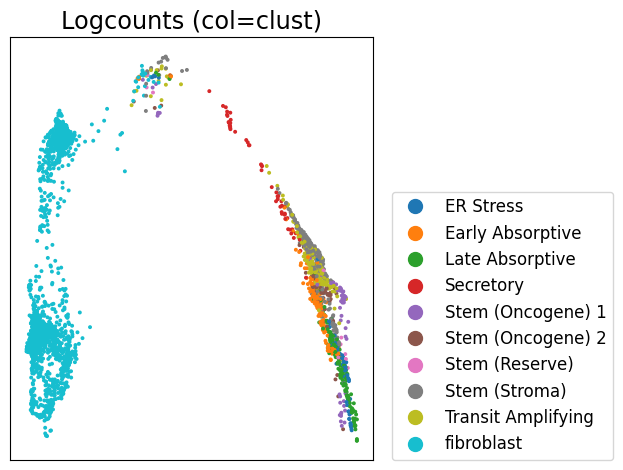

In [13]:
data_phate = phate.PHATE(n_jobs=-2, random_state=12).fit_transform(dRnaSeq) 
scprep.plot.scatter2d(
    data_phate, c=dSEQmd["finalPOPS"],
    title=f"Logcounts (col=clust)",
    shuffle=True, ticks=None,
    legend_loc=(1.05, 0))

### Scale MAGIC normalised data

In [14]:
# #Cell-scalled GEX:
# dScalRnaSeq = dRnaSeq.div(dRnaSeq.sum(axis=1), axis=0)
# dScalRnaSeq

### Match genes in KG and scRNA-seq

In [16]:
import json
with open(f"{data_dir}/customLRT_KGEtransr_entityIDS.json") as infile:
    customLRT_entityIDS = json.load(infile)

with open(f"{data_dir}/customLRT_KGEtransr_relationIDS.json") as infile:
    customLRT_relationIDS = json.load(infile)

In [17]:
import json
with open(f"{data_dir}/omnipath_KGEtransr_entityIDS.json") as infile:
    omnipath_entityIDS = json.load(infile)

with open(f"{data_dir}/omnipath_KGEtransr_relationIDS.json") as infile:
    omnipath_relationIDS = json.load(infile)

In [18]:
dRnaSeq_customLRT = dRnaSeq.reindex(columns=list(customLRT_entityIDS.values()), fill_value=float("0"))
dRnaSeq_customLRT

,AAAS,AAMP,AATF,ABCC1,ABCD3,ABCG1,ABCG5,ABCG8,ABHD12,ABHD17C,...,ZDHHC21,ZDHHC7,ZDHHC9,ZFYVE16,ZNF217,ZNRF3,ZRANB1,ZW10,ZWILCH,ZWINT
WT__AAACCCACAGCTTCCT-1,0.000000,1.050319,0.000000,0.0,0.000000,0.0,0.000000,0.0,1.050319,0.000000,...,0.000000,0.657148,0.000000,0.0,0.000000,0.0,0.657148,0.000000,0.0,0.000000
WT__AAACCCAGTTCGAGCC-1,0.000000,0.829238,0.498218,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.498218,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
WT__AAACGAAAGAAGGATG-1,0.000000,0.469502,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.469502,0.0,0.000000,0.0,0.000000,0.469502,0.0,0.469502
WT__AAACGAAAGGAAAGGT-1,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,1.498425,...,2.073080,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,1.006978
WT__AAACGAAAGTTAACGA-1,0.000000,0.000000,0.000000,0.0,0.221506,0.0,0.000000,0.0,0.000000,0.000000,...,0.221506,0.000000,0.000000,0.0,0.221506,0.0,0.000000,0.000000,0.0,0.911369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WT__TTTGGTTTCATTCTTG-1,0.000000,0.000000,0.000000,0.0,0.695505,0.0,0.000000,0.0,0.695505,1.101755,...,0.000000,0.695505,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,1.101755
WT__TTTGGTTTCCGTAGTA-1,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.824283,0.000000,0.000000,0.0,0.494771,0.0,0.000000,0.000000,0.0,0.494771
WT__TTTGTTGTCGCTTGAA-1,0.000000,0.000000,0.000000,0.0,0.461624,0.0,0.776245,0.0,0.000000,1.207942,...,0.461624,0.000000,0.461624,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
WT__TTTGTTGTCTGAATCG-1,0.249549,1.184048,0.000000,0.0,0.249549,0.0,0.000000,0.0,0.757898,0.757898,...,0.249549,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.249549,0.0,1.481914


Calculating PHATE...
  Running PHATE on 3698 observations and 2507 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.96 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.35 seconds.
    Calculating affinities...
    Calculated affinities in 0.05 seconds.
  Calculated graph and diffusion operator in 1.41 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.17 seconds.
    Calculating KMeans...
    Calculated KMeans in 4.02 seconds.
  Calculated landmark operator in 4.92 seconds.
  Calculating optimal t...
    Automatically selected t = 28
  Calculated optimal t in 2.37 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.65 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 5.69 seconds.
Calculated PHATE in 15.05 seconds.


/var/home/ferran/miniconda3/envs/collab/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Axes: title={'center': 'Logcounts (col=clust)'}>

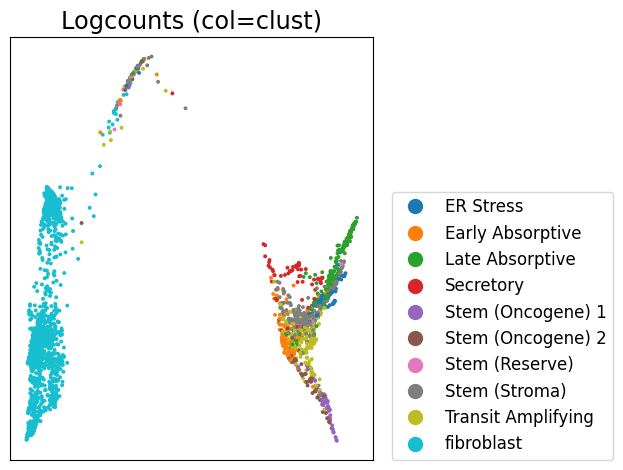

In [19]:
data_phate = phate.PHATE(n_jobs=-2, random_state=12).fit_transform(dRnaSeq_customLRT) 
scprep.plot.scatter2d(
    data_phate, c=dSEQmd["finalPOPS"],
    title=f"Logcounts (col=clust)",
    shuffle=True, ticks=None,
    legend_loc=(1.05, 0))

In [20]:
dRnaSeq_omnipath = dRnaSeq.reindex(columns=list(omnipath_entityIDS.values()), fill_value=float("0"))
dRnaSeq_omnipath

,A1BG,A2M,AAAS_AHCTF1_GLE1_NDC1_NUP107_NUP133_NUP153_NUP155_NUP160_NUP188_NUP205_NUP210_NUP214_NUP35_NUP37_NUP42_NUP43_NUP50_NUP54_NUP58_NUP62_NUP85_NUP88_NUP93_NUP98_POM121_RAE1_RANBP2_SEC13_SEH1L_TPR,AAK1,AANAT,AATF,AATK,ABCA1,ABCA7,ABCB1,...,ZP3,ZPBP2,ZPR1,ZRANB1,ZRANB2,ZSWIM2,ZW10,ZWINT,ZXDC,ZYX
WT__AAACCCACAGCTTCCT-1,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.657148,0.657148,0.0,0.000000,0.000000,0.000000,0.657148
WT__AAACCCAGTTCGAGCC-1,0.0,0.0,0.0,0.829238,0.0,0.498218,0.0,0.000000,0.498218,0.249109,...,0.0,0.0,0.000000,0.000000,1.441949,0.0,0.000000,0.000000,0.000000,0.498218
WT__AAACGAAAGAAGGATG-1,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,1.028759,0.0,0.469502,0.469502,0.469502,1.028759
WT__AAACGAAAGGAAAGGT-1,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.503489,...,0.0,0.0,0.000000,0.000000,1.006978,0.0,0.000000,1.006978,0.000000,0.000000
WT__AAACGAAAGTTAACGA-1,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.403187,...,0.0,0.0,0.000000,0.000000,0.806374,0.0,0.000000,0.911369,0.221506,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WT__TTTGGTTTCATTCTTG-1,0.0,0.0,0.0,0.695505,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,1.613209,0.0,0.000000,1.101755,0.000000,0.000000
WT__TTTGGTTTCCGTAGTA-1,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.824283,0.0,0.000000,0.494771,0.000000,0.000000
WT__TTTGTTGTCGCTTGAA-1,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.230812,...,0.0,0.0,0.000000,0.000000,0.461624,0.0,0.000000,0.000000,0.000000,0.461624
WT__TTTGTTGTCTGAATCG-1,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.249549,0.249549,0.000000,...,0.0,0.0,0.449095,0.000000,0.757898,0.0,0.249549,1.481914,0.000000,0.993504


Calculating PHATE...
  Running PHATE on 3698 observations and 9248 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 6.00 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.46 seconds.
    Calculating affinities...
    Calculated affinities in 0.04 seconds.
  Calculated graph and diffusion operator in 6.71 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.18 seconds.
    Calculating KMeans...
    Calculated KMeans in 4.32 seconds.
  Calculated landmark operator in 5.32 seconds.
  Calculating optimal t...
    Automatically selected t = 21
  Calculated optimal t in 2.03 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.88 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 5.67 seconds.
Calculated PHATE in 20.63 seconds.


/var/home/ferran/miniconda3/envs/collab/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Axes: title={'center': 'Logcounts (col=clust)'}>

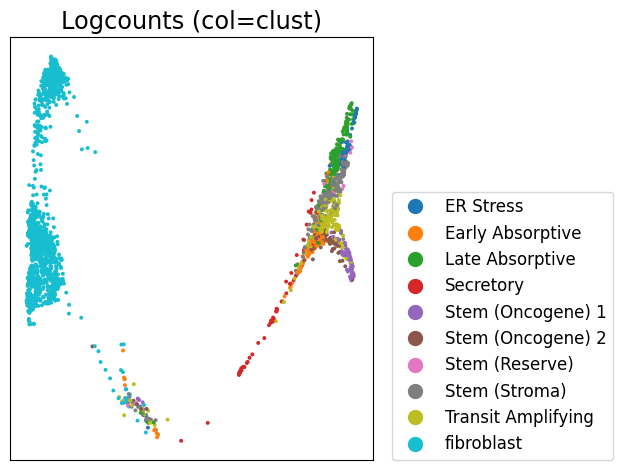

In [21]:
data_phate = phate.PHATE(n_jobs=-2, random_state=12).fit_transform(dRnaSeq_omnipath) 
scprep.plot.scatter2d(
    data_phate, c=dSEQmd["finalPOPS"],
    title=f"Logcounts (col=clust)",
    shuffle=True, ticks=None,
    legend_loc=(1.05, 0))

## customLRT KGE

In [22]:
dKGlrt = pd.read_csv(f"{data_dir}/dKGlrt.csv.tar.gz", header=None)
dKGlrt

,0,1,2
0,CXCL1,Signaling by GPCR,CXCR2
1,CXCL2,Signaling by GPCR,CXCR2
2,CXCL3,Signaling by GPCR,CXCR2
3,CXCL5,Signaling by GPCR,CXCR2
4,PPBP,Signaling by GPCR,CXCR2
...,...,...,...
97052,LGR4,Signaling by WNT,HIST1H2BO
97053,LGR4,Signaling by WNT,HIST1H2BH
97054,LGR4,Signaling by WNT,PSMB3
97055,LGR4,Signaling by WNT,HIST1H2BB


In [23]:
from pykeen.pipeline import pipeline
from pykeen.triples import TriplesFactory

modelKGE = "customLRT_50_unstratified_stopped_TransR"

tf = TriplesFactory.from_labeled_triples(
        dKGlrt.to_numpy(dtype="str"),create_inverse_triples=("inverse" in modelKGE))
print(tf)

try:
    trained_model = torch.load(f"{kge_dir}/{modelKGE}/trained_model.pkl")
except RuntimeError:
    trained_model = torch.load(f"{kge_dir}/{modelKGE}/trained_model.pkl",
    map_location=torch.device("cpu"))

print(trained_model)

TriplesFactory(num_entities=2507, num_relations=23, create_inverse_triples=False, num_triples=97057)
TransR(
  (loss): MarginRankingLoss(
    (margin_activation): ReLU()
  )
  (interaction): TransRInteraction()
  (entity_representations): ModuleList(
    (0): Embedding(
      (_embeddings): Embedding(2507, 50)
    )
  )
  (relation_representations): ModuleList(
    (0): Embedding(
      (_embeddings): Embedding(23, 30)
    )
    (1): Embedding(
      (_embeddings): Embedding(23, 1500)
    )
  )
  (weight_regularizers): ModuleList()
)


In [24]:
#Construct nodes dataframe: detach() for now is meaningless as compute is CPU
entity_embeddings = trained_model.entity_representations[0](indices=None).detach().cpu().numpy()
KGEcustomLRT = pd.DataFrame(entity_embeddings, index=customLRT_entityIDS.values())
KGEcustomLRT

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
AAAS,-0.201149,-0.218883,0.020049,0.288104,-0.066969,0.170632,-0.322887,-0.079326,-0.101365,0.022392,...,0.053724,0.061619,-0.245615,-0.110809,0.073288,-0.063230,-0.073141,-0.029983,-0.189481,-0.039863
AAMP,0.020951,-0.291592,0.138468,-0.031830,0.037229,0.097661,-0.178221,-0.361847,-0.107483,-0.171954,...,-0.029712,-0.056342,-0.044399,-0.103038,-0.104707,0.109106,0.094820,-0.108496,0.069959,-0.043669
AATF,0.085083,-0.094235,-0.017311,0.234901,0.062033,-0.097160,0.049620,0.137447,-0.006073,0.163676,...,0.206305,0.214235,-0.082344,-0.094646,-0.146063,0.066738,0.252404,-0.203899,-0.296347,-0.032439
ABCC1,-0.119740,-0.185241,0.173619,0.149668,-0.315456,0.076847,-0.173103,-0.193997,-0.217596,-0.176079,...,0.227803,-0.057589,-0.114751,-0.017054,-0.018978,0.033963,0.081139,-0.015416,-0.249233,0.108095
ABCD3,-0.112624,-0.023640,-0.127329,0.056583,0.007089,0.024257,-0.090809,0.040193,-0.170463,0.002029,...,0.023380,-0.002311,0.091811,0.071431,-0.063530,-0.006602,-0.071628,-0.168155,-0.240646,-0.123966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNRF3,-0.023284,-0.043150,0.093468,0.016122,-0.133373,-0.048538,-0.142818,0.142023,0.080462,0.110987,...,-0.196290,0.121376,0.031408,-0.052333,0.071770,0.071192,0.161012,0.143996,0.084458,0.266876
ZRANB1,0.168557,-0.082377,0.124859,-0.045588,0.080119,-0.154988,-0.111201,0.090919,0.056552,0.019166,...,-0.163922,0.196450,-0.027047,-0.145925,0.053214,0.039090,0.064877,0.120903,-0.099010,0.097119
ZW10,-0.043946,-0.221952,0.120424,-0.141735,0.245929,0.035207,0.069325,0.133197,-0.094728,0.343620,...,-0.114138,0.186758,-0.090189,0.019934,0.140588,0.194385,0.149962,-0.198785,0.053518,-0.238291
ZWILCH,0.047290,-0.173978,-0.212108,0.104762,-0.099421,0.121642,-0.278216,0.059533,-0.235186,0.136705,...,-0.103069,0.245683,-0.171601,0.266093,-0.068662,0.198846,-0.146907,0.177667,-0.038137,-0.133198


## omnipath KGE


In [25]:
dOMNIpath = pd.read_csv(f"{data_dir}/dOMNIpath.csv.tar.gz")
dOMNIpath

,source_genesymbol,pathway,target_genesymbol
0,CALM3,undetermined,TRPC1
1,CALM2,undetermined,TRPC1
2,CALM1,undetermined,TRPC1
3,CAV1,undetermined,TRPC1
4,DRD2,undetermined,TRPC1
...,...,...,...
94831,MET,Signaling by Receptor Tyrosine Kinases,HGS
94832,MET,Signaling by Receptor Tyrosine Kinases,RANBP10
94833,LCK,undetermined,CD44
94834,ERBB2,Signaling by Receptor Tyrosine Kinases,SOS1


In [26]:
from pykeen.pipeline import pipeline
from pykeen.triples import TriplesFactory

modelKGE = "omnipath_50_unstratified_stopped_TransR"

tf = TriplesFactory.from_labeled_triples(
        dOMNIpath.to_numpy(dtype="str"),create_inverse_triples=("inverse" in modelKGE))
print(tf)

try:
    trained_model = torch.load(f"{kge_dir}/{modelKGE}/trained_model.pkl")
except RuntimeError:
    trained_model = torch.load(f"{kge_dir}/{modelKGE}/trained_model.pkl",
    map_location=torch.device("cpu"))

print(trained_model)

TriplesFactory(num_entities=9248, num_relations=34, create_inverse_triples=False, num_triples=94836)
TransR(
  (loss): MarginRankingLoss(
    (margin_activation): ReLU()
  )
  (interaction): TransRInteraction()
  (entity_representations): ModuleList(
    (0): Embedding(
      (_embeddings): Embedding(9248, 50)
    )
  )
  (relation_representations): ModuleList(
    (0): Embedding(
      (_embeddings): Embedding(34, 30)
    )
    (1): Embedding(
      (_embeddings): Embedding(34, 1500)
    )
  )
  (weight_regularizers): ModuleList()
)


In [27]:
#Construct nodes dataframe: detach() for now is meaningless as compute is CPU
entity_embeddings = trained_model.entity_representations[0](indices=None).detach().cpu().numpy()
KGEomnipath = pd.DataFrame(entity_embeddings, index=omnipath_entityIDS.values())
KGEomnipath

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
A1BG,-0.080518,-0.002886,-0.201676,0.231878,0.060511,-0.144366,-0.022516,-0.128234,0.110822,0.037869,...,-0.327768,-0.197551,0.050698,-0.037682,-0.032456,0.158162,-0.111269,0.130339,0.092071,0.249119
A2M,0.067031,0.115661,-0.118946,-0.166211,0.089859,-0.219253,0.160992,0.226120,-0.146144,-0.105670,...,-0.179148,-0.004175,-0.128967,0.118978,0.082119,-0.125023,0.077265,0.185390,0.004854,-0.064574
AAAS_AHCTF1_GLE1_NDC1_NUP107_NUP133_NUP153_NUP155_NUP160_NUP188_NUP205_NUP210_NUP214_NUP35_NUP37_NUP42_NUP43_NUP50_NUP54_NUP58_NUP62_NUP85_NUP88_NUP93_NUP98_POM121_RAE1_RANBP2_SEC13_SEH1L_TPR,0.085287,0.144817,0.079706,-0.074652,-0.038562,-0.119239,-0.101849,-0.046319,-0.215106,-0.089048,...,0.325032,-0.088846,0.133048,0.176432,-0.073694,0.041630,-0.087814,0.052406,-0.137554,-0.102463
AAK1,0.064915,0.164954,0.067007,0.168932,-0.198999,0.074264,0.236824,-0.199302,-0.108452,-0.133486,...,0.086013,0.011504,0.053695,0.068632,0.016342,0.153701,-0.049259,0.053753,0.068398,-0.107745
AANAT,-0.252148,-0.123217,-0.033732,0.138275,-0.113590,-0.123411,-0.037465,-0.058101,0.164163,0.143617,...,-0.250177,0.100979,0.195180,-0.241866,0.096497,-0.058701,-0.017707,-0.091152,0.118553,0.008501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZSWIM2,0.315815,0.150141,-0.041401,-0.351691,0.065412,0.115887,0.106107,0.064609,-0.122687,0.158876,...,0.056886,-0.194193,0.010791,0.203525,-0.021326,0.050690,0.039889,-0.030665,0.073974,-0.143247
ZW10,-0.339325,0.069951,0.097021,-0.042529,0.075226,-0.061328,0.330582,-0.027842,-0.075131,0.104044,...,-0.191889,0.222940,-0.137369,-0.080473,-0.071766,-0.063291,-0.006589,-0.036125,-0.131111,0.225433
ZWINT,-0.034784,0.005585,0.060476,0.045305,-0.016239,-0.107328,-0.100837,-0.079358,0.051570,0.096620,...,-0.191042,-0.076448,0.304585,-0.011491,0.090367,0.127944,0.118582,-0.200726,-0.013131,-0.143646
ZXDC,0.142789,-0.146965,-0.023282,-0.240990,0.014844,-0.032530,0.275791,0.105269,-0.180469,-0.110064,...,0.008507,-0.258781,0.165009,0.247552,-0.016935,0.020535,-0.085196,-0.186407,-0.043485,-0.060865


# Wavelet dictionaries

Compute knn graph based on KGE

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
{'has_inf_val': False, 'has_nan_value': False, 'is_not_square': False, 'diag_is_not_zero': False}
False
True


/var/home/ferran/miniconda3/envs/collab/lib/python3.9/site-packages/pygsp/plotting.py:274: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(G.coords[:, 0], G.coords[:, 1], marker='o',


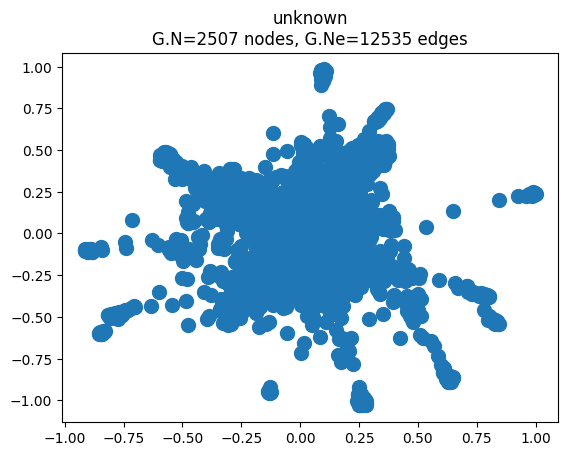

In [28]:
knnKGEcustomLRT = sklearn.neighbors.kneighbors_graph(
    KGEcustomLRT, n_neighbors = 5, mode = "connectivity",
    n_jobs = -2
)
print(knnKGEcustomLRT.toarray())
pyG_customLRT = pygsp.graphs.Graph(W=knnKGEcustomLRT)
print(pyG_customLRT.check_weights())
print(pyG_customLRT.is_connected())
print(pyG_customLRT.is_directed())
# pyG_customLRT.set_coordinates()
# pyG_customLRT.plot()

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
{'has_inf_val': False, 'has_nan_value': False, 'is_not_square': False, 'diag_is_not_zero': False}
False
True


/var/home/ferran/miniconda3/envs/collab/lib/python3.9/site-packages/pygsp/plotting.py:274: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(G.coords[:, 0], G.coords[:, 1], marker='o',


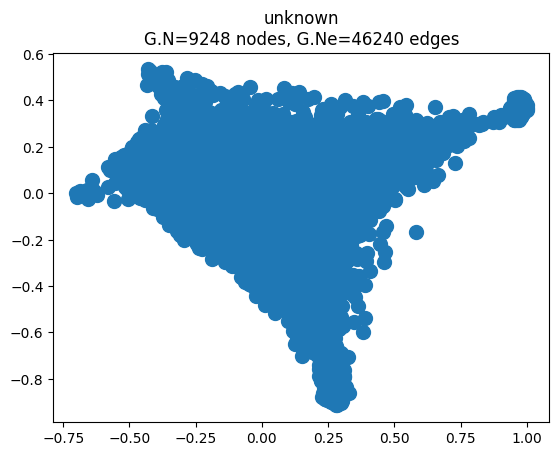

In [29]:
knnKGEomnipath = sklearn.neighbors.kneighbors_graph(
    KGEomnipath, n_neighbors = 5, mode = "connectivity",
    n_jobs = -2
)
print(knnKGEomnipath.toarray())
pyG_omnipath = pygsp.graphs.Graph(W=knnKGEomnipath)
print(pyG_omnipath.check_weights())
print(pyG_omnipath.is_connected())
print(pyG_omnipath.is_directed())
# pyG_omnipath.set_coordinates()
# pyG_omnipath.plot()

In [30]:
wavloc_customLRT = Localizer(pyG_customLRT) #Takes only pygsp graphs
wavloc_customLRT.CalculateWavelets(J=4) #J is the scale param.
wavloc_customLRT.FlattenAndNormalize()
print(wavloc_customLRT.FlatWaves.shape)
wavloc_customLRT.FlatWaves

Calculating Wavelets Using J = 4


100%|██████████| 2/2 [00:00<00:00,  5.15it/s]


Flattening and Normalizing Wavelets


100%|██████████| 4/4 [00:00<00:00, 14.71it/s]

(2507, 10028)


array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -9.96385541e-06, -6.46946654e-03,  0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00, ...,
        -4.82122036e-06, -1.63128730e-04,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         7.24769986e-01, -7.51774980e-03,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.36976227e-03,  6.41569914e-01,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -2.16633502e-04, -1.48217906e-02,  1.00000000e+00]])

When computing wavelets on multigraphs we get wavelets with NaN entries

In [31]:
pd.DataFrame(wavloc_customLRT.FlatWaves, index=list(customLRT_entityIDS.values()))

,0,1,2,3,4,5,6,7,8,9,...,10018,10019,10020,10021,10022,10023,10024,10025,10026,10027
AAAS,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,-0.000010,-6.469467e-03,0.0
AAMP,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-5.745428e-05,-8.711602e-08,0.000000e+00,0.0,-8.812016e-06,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.0
AATF,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-4.013624e-06,-4.094453e-06,-1.431682e-07,0.0,-2.731725e-04,-4.337518e-07,-3.464612e-06,-0.000005,-1.631287e-04,0.0
ABCC1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,-4.007337e-06,-7.158411e-08,0.0,-1.980228e-07,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.0
ABCD3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,-2.168759e-07,-3.387620e-06,-0.006657,-8.199030e-03,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNRF3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-7.432636e-08,0.000000e+00,0.000000e+00,0.0,-1.156453e-04,5.436291e-01,1.810754e-01,0.000000,-3.401596e-06,0.0
ZRANB1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-7.432636e-08,0.000000e+00,0.000000e+00,0.0,-9.010038e-05,2.407744e-01,6.314649e-01,0.000000,-3.697387e-07,0.0
ZW10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-7.432636e-08,0.000000e+00,0.000000e+00,0.0,0.000000e+00,-9.831708e-06,-6.944621e-05,0.724770,-7.517750e-03,0.0
ZWILCH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,-2.309741e-07,-0.001370,6.415699e-01,0.0


In [32]:
wavloc_omnipath = Localizer(pyG_omnipath) #Takes only pygsp graphs
wavloc_omnipath.CalculateWavelets(J=4) #J is the scale param.
wavloc_omnipath.FlattenAndNormalize()
print(wavloc_omnipath.FlatWaves.shape)
wavloc_omnipath.FlatWaves

Calculating Wavelets Using J = 4


100%|██████████| 2/2 [00:20<00:00, 10.42s/it]


Flattening and Normalizing Wavelets


100%|██████████| 4/4 [00:05<00:00,  1.44s/it]

(9248, 36992)


array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -3.06274904e-07, -5.91273127e-08,  0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
        -2.29706178e-07, -7.92897264e-04,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00, ...,
        -1.66154135e-05, -6.81619661e-04,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         5.13524776e-01, -6.90607013e-05,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  4.88033587e-01,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -9.44704941e-04, -1.99495553e-04,  8.35437618e-01]])

In [33]:
pd.DataFrame(wavloc_omnipath.FlatWaves, index=list(omnipath_entityIDS.values()))

,0,1,2,3,4,5,6,7,8,9,...,36982,36983,36984,36985,36986,36987,36988,36989,36990,36991
A1BG,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,-4.249291e-07,0.0,-9.260723e-04,0.000000e+00,-2.075718e-07,-0.000178,-3.062749e-07,-5.912731e-08,0.000000
A2M,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-5.225778e-06,-9.277620e-06,0.0,-1.631047e-05,-1.542460e-05,-2.423764e-03,-0.000013,-2.297062e-07,-7.928973e-04,0.000000
AAAS_AHCTF1_GLE1_NDC1_NUP107_NUP133_NUP153_NUP155_NUP160_NUP188_NUP205_NUP210_NUP214_NUP35_NUP37_NUP42_NUP43_NUP50_NUP54_NUP58_NUP62_NUP85_NUP88_NUP93_NUP98_POM121_RAE1_RANBP2_SEC13_SEH1L_TPR,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,-6.692634e-05,0.0,-7.249098e-08,0.000000e+00,-5.677090e-04,-0.000003,-1.661541e-05,-6.816197e-04,0.000000
AAK1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-2.430594e-07,-6.643059e-05,0.0,-2.278391e-04,-4.896699e-07,-1.917445e-04,-0.000009,-8.154569e-05,-1.589933e-04,0.000000
AANAT,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-1.215297e-07,-4.249291e-07,0.0,-7.430325e-05,-6.120874e-07,-6.642299e-06,-0.003884,-6.140812e-05,-2.365093e-07,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZSWIM2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,4.496849e-01,0.000000,0.000000e+00,-1.028313e-02,0.000000
ZW10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.215297e-07,-7.790368e-07,0.0,-1.306287e-04,-1.040549e-05,-1.001534e-05,0.635506,-3.062749e-07,-8.336951e-06,0.000000
ZWINT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,-9.702549e-06,0.0,-1.014874e-05,-8.789575e-05,-5.853526e-05,-0.000012,5.135248e-01,-6.906070e-05,0.000000
ZXDC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,-2.463566e-03,0.000000,0.000000e+00,4.880336e-01,0.000000


# Project data

## Projection on customLRT

In [34]:
#Multiply 2 matrices using the dot product
customLRT_projection = np.dot(dRnaSeq_customLRT, wavloc_customLRT.FlatWaves)
print(customLRT_projection.shape) #Shape should be cellsXwavelets
customLRT_projection

(3698, 10028)


array([[ 0.        ,  1.05031917,  0.        , ...,  0.0050622 ,
        -0.96334806,  0.        ],
       [ 0.        ,  0.82923826,  0.49821823, ...,  0.05708934,
        -0.8945514 ,  0.        ],
       [ 0.        ,  0.46950168,  0.        , ...,  0.22344523,
        -0.81810363,  0.46950168],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -0.20540761,
        -0.9893337 ,  0.        ],
       [ 0.2495492 ,  1.18404772,  0.        , ...,  0.03229443,
        -1.19070333,  1.48191371],
       [ 0.        ,  0.794661  ,  0.        , ..., -0.2029018 ,
        -1.04498345,  0.59284438]])

In [35]:
print(np.isnan(np.sum(customLRT_projection)))

False


In [36]:
from sklearn.impute import SimpleImputer
customLRT_projection = SimpleImputer(strategy="constant").fit_transform(customLRT_projection)
print(np.isnan(np.sum(customLRT_projection)))

False


Calculating PHATE...
  Running PHATE on 3698 observations and 10028 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 4.33 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.35 seconds.
    Calculating affinities...
    Calculated affinities in 0.05 seconds.
  Calculated graph and diffusion operator in 4.74 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.17 seconds.
    Calculating KMeans...
    Calculated KMeans in 3.20 seconds.
  Calculated landmark operator in 4.10 seconds.
  Calculating optimal t...
    Automatically selected t = 27
  Calculated optimal t in 2.08 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.94 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 4.84 seconds.
Calculated PHATE in 16.70 seconds.


/var/home/ferran/miniconda3/envs/collab/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Axes: title={'center': 'scRNAseq customLRT (col=clust)'}>

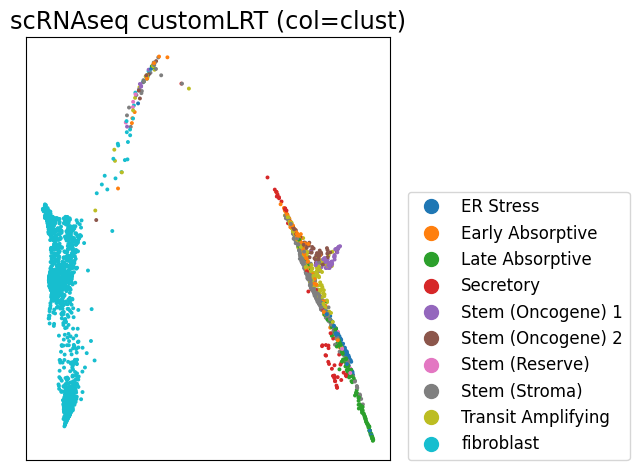

In [37]:
data_phate = phate.PHATE(n_jobs=-2, random_state=12).fit_transform(customLRT_projection) 
scprep.plot.scatter2d(
    data_phate, c=dSEQmd["finalPOPS"],
    title=f"scRNAseq customLRT (col=clust)",
    shuffle=True, ticks=None,
    legend_loc=(1.05, 0))

## Projection on omnipath

In [38]:
#Multiply 2 matrices using the dot product
omnipath_projection = np.dot(dRnaSeq_omnipath, wavloc_omnipath.FlatWaves)
print(omnipath_projection.shape) #Shape should be cellsXwavelets
omnipath_projection

(3698, 36992)


array([[ 0.        ,  0.        ,  0.        , ...,  0.53366145,
        -2.4460554 ,  0.62850882],
       [ 0.        ,  0.        ,  0.        , ...,  0.08190822,
        -2.96778438,  0.51655294],
       [ 0.        ,  0.        ,  0.        , ...,  0.33655668,
        -1.79898736,  1.0270586 ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.52594479,
        -2.63446128,  0.60794265],
       [ 0.        ,  0.        ,  0.        , ...,  1.26878875,
        -2.74319121,  1.4744195 ],
       [ 0.        ,  0.        ,  0.        , ...,  0.97788267,
        -2.59632633,  0.43284522]])

In [39]:
print(np.isnan(np.sum(omnipath_projection)))

False


In [40]:
from sklearn.impute import SimpleImputer
omnipath_projection = SimpleImputer(strategy="constant").fit_transform(omnipath_projection)
print(np.isnan(np.sum(omnipath_projection)))

False


Calculating PHATE...
  Running PHATE on 3698 observations and 36992 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 16.59 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.45 seconds.
    Calculating affinities...
    Calculated affinities in 0.04 seconds.
  Calculated graph and diffusion operator in 17.10 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.22 seconds.
    Calculating KMeans...
    Calculated KMeans in 4.35 seconds.
  Calculated landmark operator in 5.33 seconds.
  Calculating optimal t...
    Automatically selected t = 24
  Calculated optimal t in 1.91 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.78 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 5.01 seconds.
Calculated PHATE in 30.15 seconds.


/var/home/ferran/miniconda3/envs/collab/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Axes: title={'center': 'scRNAseq omnipath (col=clust)'}>

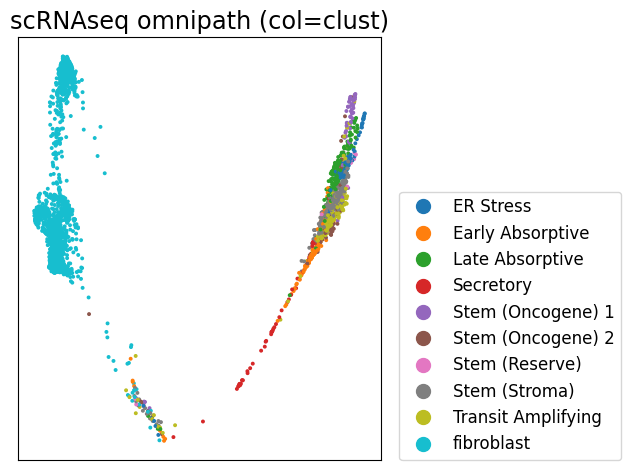

In [41]:
data_phate = phate.PHATE(n_jobs=-2, random_state=12).fit_transform(omnipath_projection) 
scprep.plot.scatter2d(
    data_phate, c=dSEQmd["finalPOPS"],
    title=f"scRNAseq omnipath (col=clust)",
    shuffle=True, ticks=None,
    legend_loc=(1.05, 0))

# Compute intercluster distances

Compute median/mean intercluster distance on GEx knn, customLRT knn, and omnipath knn

In [47]:
dRnaSeq.shape

(3698, 13794)

In [46]:
customLRT_projection.shape

(3698, 10028)

In [45]:
omnipath_projection.shape

(3698, 36992)

In [69]:
dSEQmd[["finalPOPS"]].to_dict()

{'finalPOPS': {'WT__AAACCCACAGCTTCCT-1': 'fibroblast',
  'WT__AAACCCAGTTCGAGCC-1': 'fibroblast',
  'WT__AAACGAAAGAAGGATG-1': 'fibroblast',
  'WT__AAACGAAAGGAAAGGT-1': 'Late Absorptive',
  'WT__AAACGAAAGTTAACGA-1': 'Transit Amplifying',
  'WT__AAACGAACACCAGCTG-1': 'fibroblast',
  'WT__AAACGAACACCGTGCA-1': 'fibroblast',
  'WT__AAACGAACATACTTTC-1': 'fibroblast',
  'WT__AAACGCTCACAGCCAC-1': 'fibroblast',
  'WT__AAACGCTCATGACTAC-1': 'fibroblast',
  'WT__AAACGCTGTATCCCAA-1': 'fibroblast',
  'WT__AAACGCTGTCAAGGCA-1': 'fibroblast',
  'WT__AAACGCTGTGATGGCA-1': 'fibroblast',
  'WT__AAACGCTGTTGGCCGT-1': 'fibroblast',
  'WT__AAACGCTTCACCGGGT-1': 'fibroblast',
  'WT__AAAGAACAGCAGCGAT-1': 'Stem (Stroma)',
  'WT__AAAGAACAGGCCCGTT-1': 'fibroblast',
  'WT__AAAGAACCACCAGCCA-1': 'fibroblast',
  'WT__AAAGAACCAGAACATA-1': 'fibroblast',
  'WT__AAAGAACTCTACTGAG-1': 'Stem (Oncogene) 1',
  'WT__AAAGAACTCTGAGATC-1': 'fibroblast',
  'WT__AAAGGATAGAGTCTGG-1': 'fibroblast',
  'WT__AAAGGATAGTGGACTG-1': 'fibroblast'

## Generate cell-cell graphs

In [51]:
from sklearn.decomposition import PCA

cell-cell gex similarity graph

In [57]:
gex_pca = PCA(n_components=100).fit_transform(dRnaSeq)
gex_pca = pd.DataFrame(gex_pca, index=dSEQmd[["finalPOPS"]].index)
gex_pca

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
WT__AAACCCACAGCTTCCT-1,-8.588680,1.231301,-6.507704,-1.643537,-1.253961,0.291769,1.000236,1.750140,-2.276548,-3.785204,...,-1.724568,-0.551678,0.579479,-1.383480,0.959042,1.217399,0.042871,0.618147,0.520816,-0.792239
WT__AAACCCAGTTCGAGCC-1,-9.179774,2.171085,-7.598828,-0.876342,-2.744096,4.043705,0.508315,1.738608,-2.724063,-1.775186,...,-0.173334,0.023041,0.555868,0.437603,-0.360236,-0.048044,-0.506732,-1.299580,0.630180,-1.384084
WT__AAACGAAAGAAGGATG-1,-10.743919,-0.937379,-4.465205,-2.895730,0.446634,-2.996389,1.875989,-2.805658,2.657940,0.686667,...,0.330465,0.161548,-0.481019,-0.366685,0.231676,-0.522172,-0.288607,-0.246938,-0.700552,-0.003946
WT__AAACGAAAGGAAAGGT-1,24.220099,-12.247442,-1.378553,5.970734,7.604334,3.770811,6.713848,-0.165065,3.434384,1.308580,...,-2.772617,-4.067668,-0.734238,-2.244602,0.904839,-2.483646,-3.297818,-2.599689,-0.200070,-2.142146
WT__AAACGAAAGTTAACGA-1,23.414869,-1.430956,-0.065914,-0.326091,-3.736270,-1.852298,-0.065531,-2.031737,-3.702559,-0.264320,...,0.963238,0.736958,-0.297743,-0.093602,0.133128,0.339803,-0.088108,-0.143812,0.212320,0.210216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WT__TTTGGTTTCATTCTTG-1,18.735859,-3.363562,0.065438,4.388390,2.178023,-2.836733,0.903301,7.687268,1.734449,-2.133626,...,0.314083,-0.497287,0.071848,-1.090705,0.503534,-0.240375,0.238211,1.279598,-0.906156,-1.357573
WT__TTTGGTTTCCGTAGTA-1,-9.722922,-3.134103,-9.942559,0.431887,-1.757387,1.378721,-1.153187,-0.901081,2.890428,0.639661,...,0.248501,0.119521,0.557246,-0.148793,0.227483,0.236093,-0.027258,0.592450,0.611241,-0.503265
WT__TTTGTTGTCGCTTGAA-1,25.606125,-9.127064,-0.036233,3.009288,5.659770,3.983858,4.573350,-1.886395,-1.474879,1.351438,...,0.910016,-0.222985,-1.262484,1.147792,0.040201,-0.097252,0.493869,-0.570400,1.376777,-0.280358
WT__TTTGTTGTCTGAATCG-1,-7.777471,-0.192095,12.562033,-2.423001,0.173705,1.614309,0.879682,-0.838634,0.475956,-1.234670,...,0.337189,0.069201,0.261610,-0.004119,0.178448,-0.426902,-0.489164,-0.732520,-0.626137,-0.620705


In [58]:
phate_op = phate.PHATE(n_jobs=-2, random_state=12, knn=30, use_pygsp=True)
phate_op.fit(gex_pca)
gex_knn = phate_op.graph
del(phate_op)
gex_knn

Running PHATE on 3698 observations and 100 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.27 seconds.
  Calculating affinities...
  Calculated affinities in 0.06 seconds.
Calculated graph and diffusion operator in 0.46 seconds.
Calculating landmark operator...
  Calculating SVD...
  Calculated SVD in 0.37 seconds.
  Calculating KMeans...
  Calculated KMeans in 3.86 seconds.
Calculated landmark operator in 5.09 seconds.


cell-cell customLRP projection similarity graph

In [59]:
custom_pca = PCA(n_components=100).fit_transform(customLRT_projection)
custom_pca = pd.DataFrame(custom_pca, index=dSEQmd[["finalPOPS"]].index)
custom_pca

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
WT__AAACCCACAGCTTCCT-1,-10.735499,-5.906735,-3.444131,1.516417,-2.420470,-1.480036,0.577380,-3.002165,1.252221,2.114761,...,-0.986078,0.603841,-0.028973,-1.712813,-1.099497,-1.743684,-1.622484,0.356442,1.939833,0.566887
WT__AAACCCAGTTCGAGCC-1,-9.397165,-8.964417,-5.767050,1.658373,-1.706473,2.264498,2.555450,2.103835,1.745084,0.658135,...,-1.350705,-0.535583,-0.157746,0.035962,-0.264102,1.767239,0.727261,-1.693814,-0.111886,0.237449
WT__AAACGAAAGAAGGATG-1,-10.650365,-3.888029,-4.689600,-2.370616,3.618491,1.878256,-5.292272,4.376495,0.236087,-1.016431,...,-0.267823,-1.345897,-0.469269,0.187208,-0.249312,0.745804,-2.333963,0.385291,-0.614938,-1.699688
WT__AAACGAAAGGAAAGGT-1,23.847486,15.929899,-7.909884,3.026003,12.246709,0.381267,1.421897,0.122335,0.480716,2.104408,...,1.278496,-1.774205,1.662318,-1.109092,1.155672,0.635082,-2.191951,0.623597,-2.902672,2.913839
WT__AAACGAAAGTTAACGA-1,21.592320,-0.229950,-0.593246,-0.174330,-3.949365,-1.767065,-1.349024,0.031578,-0.310794,-2.897663,...,-0.402273,0.204179,0.655423,0.332066,-0.287618,-0.149292,-0.664864,0.916664,-0.437254,0.007852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WT__TTTGGTTTCATTCTTG-1,18.732571,-0.636905,-2.771373,-2.652905,3.867280,-2.215845,-0.679121,2.282697,2.225446,5.544467,...,1.880347,-0.108875,0.126126,0.851559,-1.071489,0.295701,2.036007,0.945020,0.586759,2.775834
WT__TTTGGTTTCCGTAGTA-1,-11.102874,-4.639964,-9.776936,-0.841974,-0.333115,0.668053,-2.438572,4.142069,0.890149,1.096438,...,-1.454349,0.706176,1.119583,-0.316441,0.564234,-1.057071,-0.829224,1.215426,0.761114,0.546735
WT__TTTGTTGTCGCTTGAA-1,25.114749,11.289340,-2.605271,2.621979,3.212133,2.511439,2.417729,0.124037,2.340999,-1.419196,...,-0.473579,-1.400933,0.222905,-0.498729,0.246586,0.804418,0.963248,-1.310201,-0.752678,-0.560019
WT__TTTGTTGTCTGAATCG-1,-5.517317,8.446535,10.542684,-6.132349,-1.083587,1.112684,0.922218,4.486522,1.391601,-0.921252,...,0.140170,0.694878,0.977704,0.186941,-0.077262,-0.340364,-0.052359,-0.788862,-0.565583,-0.080677


In [60]:
phate_op = phate.PHATE(n_jobs=-2, random_state=12, knn=30, use_pygsp=True)
phate_op.fit(custom_pca)
custom_knn = phate_op.graph
del(phate_op)
custom_knn

Running PHATE on 3698 observations and 100 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.29 seconds.
  Calculating affinities...
  Calculated affinities in 0.07 seconds.
Calculated graph and diffusion operator in 0.54 seconds.
Calculating landmark operator...
  Calculating SVD...
  Calculated SVD in 0.41 seconds.
  Calculating KMeans...
  Calculated KMeans in 3.60 seconds.
Calculated landmark operator in 4.86 seconds.


cell-cell omnipath projection similarity graph

In [61]:
omni_pca = PCA(n_components=100).fit_transform(omnipath_projection)
omni_pca = pd.DataFrame(omni_pca, index=dSEQmd[["finalPOPS"]].index)
omni_pca

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
WT__AAACCCACAGCTTCCT-1,-14.336061,-2.155300,-10.977246,-1.013749,2.483484,0.279917,3.514549,5.892057,-5.515904,-0.413838,...,0.382380,-6.421564,1.591212,0.114582,-1.601537,-0.390218,-1.938432,-0.352947,1.266019,-0.180121
WT__AAACCCAGTTCGAGCC-1,-14.933479,-0.791010,-12.158494,0.781258,8.088500,4.176272,1.673525,2.115689,-3.414446,0.432519,...,0.908021,0.153634,1.314811,-2.069438,-0.519670,0.192718,-0.277699,2.254426,0.471887,0.377578
WT__AAACGAAAGAAGGATG-1,-16.841080,-4.736752,-8.045939,-4.844091,-2.300495,-4.390909,1.635968,-6.334380,1.057220,4.336522,...,0.224039,1.176249,-0.576966,-1.168087,0.984617,-0.835471,-0.515915,1.159029,0.420441,1.175548
WT__AAACGAAAGGAAAGGT-1,36.639029,-15.030295,3.927994,6.161299,-9.993174,7.663849,11.495873,-3.352653,2.806316,3.766465,...,0.946115,-0.603398,-1.014446,3.412087,4.489186,-1.106290,-1.161057,1.490381,-0.710545,-1.224286
WT__AAACGAAAGTTAACGA-1,37.694015,-3.226507,1.553658,-0.487199,4.045217,-5.421390,-0.261946,0.138471,-1.708309,-4.884465,...,-0.270435,-0.483328,0.236255,0.585994,-0.811069,0.080626,0.760568,-0.193586,0.025207,0.962000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WT__TTTGGTTTCATTCTTG-1,30.758774,-5.252513,1.879744,3.723366,-6.749032,1.077902,4.510759,6.804354,1.527980,7.943306,...,1.293198,-1.125527,1.541074,-0.495808,1.982847,2.172711,-2.337097,-1.123463,-0.229033,2.023605
WT__TTTGGTTTCCGTAGTA-1,-16.980100,-9.389737,-10.459046,2.644868,4.328097,0.345881,-1.706280,-4.724042,1.078272,4.821639,...,0.200951,1.612669,0.553034,0.882346,0.637780,0.461493,0.807781,1.658218,-0.757554,0.000517
WT__TTTGTTGTCGCTTGAA-1,38.998431,-10.086575,5.131781,7.281114,-3.287918,6.996584,7.422708,-5.172892,3.302103,-0.193031,...,1.074375,0.518089,1.044154,-0.088122,0.854441,-2.988559,1.768335,0.207343,-1.372240,-0.620342
WT__TTTGTTGTCTGAATCG-1,-12.839691,7.067778,19.381055,-6.893742,0.770184,1.250938,2.046110,-3.963704,-1.439204,0.376583,...,0.813080,-0.216570,1.095015,0.076693,0.226742,-1.215195,-0.105822,-0.265390,-0.062520,1.109725


In [62]:
phate_op = phate.PHATE(n_jobs=-2, random_state=12, knn=30, use_pygsp=True)
phate_op.fit(omni_pca)
omni_knn = phate_op.graph
del(phate_op)
omni_knn

Running PHATE on 3698 observations and 100 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.35 seconds.
  Calculating affinities...
  Calculated affinities in 0.07 seconds.
Calculated graph and diffusion operator in 0.78 seconds.
Calculating landmark operator...
  Calculating SVD...
  Calculated SVD in 0.39 seconds.
  Calculating KMeans...
  Calculated KMeans in 3.98 seconds.
Calculated landmark operator in 5.25 seconds.


In [63]:
gex_knn
custom_knn
omni_knn

## Compute distances to/from all cells

In [65]:
gex_dist = pd.DataFrame(gex_knn.shortest_path(), index=dSEQmd.index, columns=dSEQmd.index)
gex_dist

Using negative log affinity distances.


,WT__AAACCCACAGCTTCCT-1,WT__AAACCCAGTTCGAGCC-1,WT__AAACGAAAGAAGGATG-1,WT__AAACGAAAGGAAAGGT-1,WT__AAACGAAAGTTAACGA-1,WT__AAACGAACACCAGCTG-1,WT__AAACGAACACCGTGCA-1,WT__AAACGAACATACTTTC-1,WT__AAACGCTCACAGCCAC-1,WT__AAACGCTCATGACTAC-1,...,WT__TTTGATCGTGTTAGCT-1,WT__TTTGATCTCTCATGGA-1,WT__TTTGGAGCAACGCCCA-1,WT__TTTGGAGGTACCATAC-1,WT__TTTGGTTAGCGGGTAT-1,WT__TTTGGTTTCATTCTTG-1,WT__TTTGGTTTCCGTAGTA-1,WT__TTTGTTGTCGCTTGAA-1,WT__TTTGTTGTCTGAATCG-1,WT__TTTGTTGTCTGGGTCG-1
WT__AAACCCACAGCTTCCT-1,0.000000,0.738655,0.800472,1.791438,1.098121,0.738986,0.759799,0.744345,0.750604,1.484629,...,0.812388,1.097989,1.279644,1.442312,0.754925,1.098052,0.758476,1.132215,0.741047,1.097873
WT__AAACCCAGTTCGAGCC-1,0.738655,0.000000,0.066762,1.055766,0.362449,0.003315,0.036849,0.019395,0.014932,0.748957,...,0.076716,0.362317,0.548413,0.711081,0.023019,0.362380,0.031046,0.396544,0.005375,0.362201
WT__AAACGAAAGAAGGATG-1,0.800472,0.066762,0.000000,1.118916,0.425600,0.066465,0.088602,0.074566,0.078083,0.806476,...,0.139213,0.425467,0.603765,0.766433,0.079046,0.425530,0.084339,0.459694,0.068526,0.425351
WT__AAACGAAAGGAAAGGT-1,1.791438,1.055766,1.118916,0.000000,0.693628,1.052452,1.089004,1.071550,1.064172,1.801112,...,1.125956,0.693469,1.601195,1.763864,1.072259,0.693728,1.083828,0.728027,1.054615,0.693677
WT__AAACGAAAGTTAACGA-1,1.098121,0.362449,0.425600,0.693628,0.000000,0.359135,0.395687,0.378233,0.370855,1.107795,...,0.432639,0.000316,0.907878,1.070547,0.378942,0.000575,0.390511,0.034873,0.361298,0.000361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WT__TTTGGTTTCATTCTTG-1,1.098052,0.362380,0.425530,0.693728,0.000575,0.359065,0.395618,0.378164,0.370786,1.107726,...,0.432570,0.000322,0.907809,1.070478,0.378873,0.000000,0.390442,0.034547,0.361229,0.000549
WT__TTTGGTTTCCGTAGTA-1,0.758476,0.031046,0.084339,1.083828,0.390511,0.031377,0.045316,0.031279,0.042995,0.776138,...,0.102190,0.390379,0.565570,0.728238,0.040851,0.390442,0.000000,0.424606,0.033438,0.390263
WT__TTTGTTGTCGCTTGAA-1,1.132215,0.396544,0.459694,0.728027,0.034873,0.393229,0.429781,0.412327,0.404950,1.141889,...,0.466734,0.034715,0.941973,1.104641,0.413036,0.034547,0.424606,0.000000,0.395393,0.034920
WT__TTTGTTGTCTGAATCG-1,0.741047,0.005375,0.068526,1.054615,0.361298,0.002164,0.038613,0.021159,0.012230,0.750721,...,0.074619,0.361166,0.550805,0.713473,0.020957,0.361229,0.033438,0.395393,0.000000,0.361050


In [66]:
custom_dist = pd.DataFrame(custom_knn.shortest_path(), index=dSEQmd.index, columns=dSEQmd.index)
custom_dist

Using negative log affinity distances.


,WT__AAACCCACAGCTTCCT-1,WT__AAACCCAGTTCGAGCC-1,WT__AAACGAAAGAAGGATG-1,WT__AAACGAAAGGAAAGGT-1,WT__AAACGAAAGTTAACGA-1,WT__AAACGAACACCAGCTG-1,WT__AAACGAACACCGTGCA-1,WT__AAACGAACATACTTTC-1,WT__AAACGCTCACAGCCAC-1,WT__AAACGCTCATGACTAC-1,...,WT__TTTGATCGTGTTAGCT-1,WT__TTTGATCTCTCATGGA-1,WT__TTTGGAGCAACGCCCA-1,WT__TTTGGAGGTACCATAC-1,WT__TTTGGTTAGCGGGTAT-1,WT__TTTGGTTTCATTCTTG-1,WT__TTTGGTTTCCGTAGTA-1,WT__TTTGTTGTCGCTTGAA-1,WT__TTTGTTGTCTGAATCG-1,WT__TTTGTTGTCTGGGTCG-1
WT__AAACCCACAGCTTCCT-1,0.000000,0.639339,0.692117,1.683051,1.252406,0.605226,0.742482,0.619792,0.626564,1.309367,...,1.220733,1.253902,1.337608,1.146305,1.009040,1.255974,0.642092,1.271539,0.626953,1.254262
WT__AAACCCAGTTCGAGCC-1,0.639339,0.000000,0.175594,1.135915,0.705270,0.042934,0.185447,0.075414,0.067474,0.784759,...,0.678289,0.706766,0.817224,0.616069,0.474980,0.708837,0.125569,0.724403,0.069949,0.707126
WT__AAACGAAAGAAGGATG-1,0.692117,0.175594,0.000000,1.219307,0.788662,0.135180,0.269724,0.153484,0.159719,0.838308,...,0.756822,0.790158,0.872358,0.669618,0.516443,0.792229,0.170994,0.807795,0.162194,0.790518
WT__AAACGAAAGGAAAGGT-1,1.683051,1.135915,1.219307,0.000000,0.434231,1.101803,1.239058,1.131082,1.123141,1.842525,...,1.731901,0.435762,1.861315,1.671211,1.532746,0.436563,1.169282,0.452104,1.123530,0.435387
WT__AAACGAAAGTTAACGA-1,1.252406,0.705270,0.788662,0.434231,0.000000,0.671157,0.808413,0.700437,0.692496,1.411880,...,1.301255,0.003277,1.430669,1.240566,1.102101,0.005195,0.738637,0.022719,0.692884,0.002029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WT__TTTGGTTTCATTCTTG-1,1.255974,0.708837,0.792229,0.436563,0.005195,0.674725,0.811981,0.704004,0.696063,1.415447,...,1.304823,0.008472,1.434237,1.244133,1.105669,0.000000,0.742204,0.025051,0.696452,0.006261
WT__TTTGGTTTCCGTAGTA-1,0.642092,0.125569,0.170994,1.169282,0.738637,0.089269,0.212576,0.081798,0.112795,0.776668,...,0.682739,0.740132,0.807580,0.612471,0.470020,0.742204,0.000000,0.757770,0.113183,0.740493
WT__TTTGTTGTCGCTTGAA-1,1.271539,0.724403,0.807795,0.452104,0.022719,0.690290,0.827546,0.719570,0.711629,1.431013,...,1.320388,0.024249,1.449802,1.259699,1.121234,0.025051,0.757770,0.000000,0.712017,0.023875
WT__TTTGTTGTCTGAATCG-1,0.626953,0.069949,0.162194,1.123530,0.692884,0.029036,0.164693,0.053246,0.036896,0.768454,...,0.657536,0.694380,0.798273,0.596846,0.461083,0.696452,0.113183,0.712017,0.000000,0.694740


In [67]:
omni_dist = pd.DataFrame(omni_knn.shortest_path(), index=dSEQmd.index, columns=dSEQmd.index)
omni_dist

Using negative log affinity distances.


,WT__AAACCCACAGCTTCCT-1,WT__AAACCCAGTTCGAGCC-1,WT__AAACGAAAGAAGGATG-1,WT__AAACGAAAGGAAAGGT-1,WT__AAACGAAAGTTAACGA-1,WT__AAACGAACACCAGCTG-1,WT__AAACGAACACCGTGCA-1,WT__AAACGAACATACTTTC-1,WT__AAACGCTCACAGCCAC-1,WT__AAACGCTCATGACTAC-1,...,WT__TTTGATCGTGTTAGCT-1,WT__TTTGATCTCTCATGGA-1,WT__TTTGGAGCAACGCCCA-1,WT__TTTGGAGGTACCATAC-1,WT__TTTGGTTAGCGGGTAT-1,WT__TTTGGTTTCATTCTTG-1,WT__TTTGGTTTCCGTAGTA-1,WT__TTTGTTGTCGCTTGAA-1,WT__TTTGTTGTCTGAATCG-1,WT__TTTGTTGTCTGGGTCG-1
WT__AAACCCACAGCTTCCT-1,0.000000,0.719773,0.852321,1.797919,1.406252,0.716469,0.745441,0.731670,0.727164,1.505642,...,0.778607,1.405947,1.092043,1.416885,0.803572,1.407070,0.761473,1.424075,0.718194,1.406355
WT__AAACCCAGTTCGAGCC-1,0.719773,0.000000,0.158418,1.092969,0.701301,0.011518,0.050659,0.036846,0.022214,0.799974,...,0.073657,0.700997,0.399494,0.713423,0.104749,0.702120,0.067570,0.719124,0.013244,0.701404
WT__AAACGAAAGAAGGATG-1,0.852321,0.158418,0.000000,1.236564,0.844896,0.155113,0.176297,0.158412,0.165809,0.944784,...,0.217252,0.844592,0.528071,0.852914,0.236294,0.845715,0.151029,0.862719,0.156839,0.844999
WT__AAACGAAAGGAAAGGT-1,1.797919,1.092969,1.236564,0.000000,0.391858,1.081898,1.127938,1.110781,1.092062,1.879335,...,1.143298,0.391977,1.476433,1.791569,1.182895,0.393095,1.145716,0.409989,1.083092,0.391987
WT__AAACGAAAGTTAACGA-1,1.406252,0.701301,0.844896,0.391858,0.000000,0.690231,0.736270,0.719113,0.700395,1.487668,...,0.751630,0.000309,1.084765,1.399902,0.791228,0.001548,0.754049,0.018469,0.691425,0.000319
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WT__TTTGGTTTCATTCTTG-1,1.407070,0.702120,0.845715,0.393095,0.001548,0.691049,0.737089,0.719932,0.701214,1.488486,...,0.752449,0.001244,1.085584,1.400721,0.792046,0.000000,0.754867,0.017531,0.692244,0.001651
WT__TTTGGTTTCCGTAGTA-1,0.761473,0.067570,0.151029,1.145716,0.754049,0.064266,0.085449,0.067564,0.074961,0.853937,...,0.126404,0.753744,0.437224,0.762066,0.145446,0.754867,0.000000,0.771872,0.065991,0.754152
WT__TTTGTTGTCGCTTGAA-1,1.424075,0.719124,0.862719,0.409989,0.018469,0.708054,0.754094,0.736936,0.718218,1.505491,...,0.769454,0.018248,1.102588,1.417725,0.809051,0.017531,0.771872,0.000000,0.709248,0.018572
WT__TTTGTTGTCTGAATCG-1,0.718194,0.013244,0.156839,1.083092,0.691425,0.002173,0.048346,0.030991,0.011922,0.799610,...,0.063716,0.691120,0.396643,0.711844,0.103170,0.692244,0.065991,0.709248,0.000000,0.691528


## View distances

In [108]:
clusters = sorted(set(dSEQmd["finalPOPS"].to_dict().values()))

In [120]:
new_matrix = np.zeros((len(clusters), len(clusters)))

for i, group_i in enumerate(clusters):
    for j, group_j in enumerate(clusters):
        if i != j:
            group_i_indices = [k for k, v in dSEQmd["finalPOPS"].to_dict().items() if v == group_i]
            group_j_indices = [k for k, v in dSEQmd["finalPOPS"].to_dict().items() if v == group_j]
            submatrix = gex_dist.loc[group_i_indices, group_j_indices]
            mean_distance = submatrix.mean().mean()
            new_matrix[i, j] = mean_distance

gex_matrix = pd.DataFrame(index=clusters, columns=clusters, data=new_matrix)
gex_matrix.style.background_gradient(cmap="binary", low=0, high=1.0,vmin=0, vmax=1.0)

,ER Stress,Early Absorptive,Late Absorptive,Secretory,Stem (Oncogene) 1,Stem (Oncogene) 2,Stem (Reserve),Stem (Stroma),Transit Amplifying,fibroblast
ER Stress,0.000000,0.080695,0.052543,0.076404,0.091292,0.080815,0.280759,0.078022,0.109683,0.444168
Early Absorptive,0.080695,0.000000,0.066277,0.089929,0.105837,0.095224,0.297108,0.092242,0.123896,0.467273
Late Absorptive,0.052543,0.066277,0.000000,0.059810,0.078714,0.067775,0.274647,0.063894,0.095865,0.464264
Secretory,0.076404,0.089929,0.059810,0.000000,0.102960,0.091863,0.301084,0.087636,0.119706,0.499108
Stem (Oncogene) 1,0.091292,0.105837,0.078714,0.102960,0.000000,0.104863,0.300759,0.102925,0.134226,0.447442
Stem (Oncogene) 2,0.080815,0.095224,0.067775,0.091863,0.104863,0.000000,0.292043,0.092439,0.123829,0.444674
Stem (Reserve),0.280759,0.297108,0.274647,0.301084,0.300759,0.292043,0.000000,0.293511,0.323701,0.530406
Stem (Stroma),0.078022,0.092242,0.063894,0.087636,0.102925,0.092439,0.293511,0.000000,0.121133,0.461019
Transit Amplifying,0.109683,0.123896,0.095865,0.119706,0.134226,0.123829,0.323701,0.121133,0.000000,0.486239
fibroblast,0.444168,0.467273,0.464264,0.499108,0.447442,0.444674,0.530406,0.461019,0.486239,0.000000


In [121]:
new_matrix = np.zeros((len(clusters), len(clusters)))

for i, group_i in enumerate(clusters):
    for j, group_j in enumerate(clusters):
        if i != j:
            group_i_indices = [k for k, v in dSEQmd["finalPOPS"].to_dict().items() if v == group_i]
            group_j_indices = [k for k, v in dSEQmd["finalPOPS"].to_dict().items() if v == group_j]
            submatrix = custom_dist.loc[group_i_indices, group_j_indices]
            mean_distance = submatrix.mean().mean()
            new_matrix[i, j] = mean_distance

custom_matrix = pd.DataFrame(index=clusters, columns=clusters, data=new_matrix)
custom_matrix.style.background_gradient(cmap="binary", low=0, high=1.0,vmin=0, vmax=1.0)

,ER Stress,Early Absorptive,Late Absorptive,Secretory,Stem (Oncogene) 1,Stem (Oncogene) 2,Stem (Reserve),Stem (Stroma),Transit Amplifying,fibroblast
ER Stress,0.000000,0.193480,0.122857,0.120027,0.190578,0.205960,0.598664,0.177634,0.245331,0.808159
Early Absorptive,0.193480,0.000000,0.140741,0.136137,0.210426,0.224887,0.623456,0.196697,0.264117,0.845204
Late Absorptive,0.122857,0.140741,0.000000,0.063282,0.142080,0.156256,0.564643,0.125914,0.194180,0.826064
Secretory,0.120027,0.136137,0.063282,0.000000,0.139482,0.152999,0.563362,0.122677,0.190845,0.830325
Stem (Oncogene) 1,0.190578,0.210426,0.142080,0.139482,0.000000,0.218896,0.606906,0.193225,0.259654,0.783799
Stem (Oncogene) 2,0.205960,0.224887,0.156256,0.152999,0.218896,0.000000,0.625675,0.208758,0.275413,0.813351
Stem (Reserve),0.598664,0.623456,0.564643,0.563362,0.606906,0.625675,0.000000,0.604039,0.668485,0.978409
Stem (Stroma),0.177634,0.196697,0.125914,0.122677,0.193225,0.208758,0.604039,0.000000,0.247423,0.824591
Transit Amplifying,0.245331,0.264117,0.194180,0.190845,0.259654,0.275413,0.668485,0.247423,0.000000,0.878698
fibroblast,0.808159,0.845204,0.826064,0.830325,0.783799,0.813351,0.978409,0.824591,0.878698,0.000000


In [122]:
new_matrix = np.zeros((len(clusters), len(clusters)))

for i, group_i in enumerate(clusters):
    for j, group_j in enumerate(clusters):
        if i != j:
            group_i_indices = [k for k, v in dSEQmd["finalPOPS"].to_dict().items() if v == group_i]
            group_j_indices = [k for k, v in dSEQmd["finalPOPS"].to_dict().items() if v == group_j]
            submatrix = omni_dist.loc[group_i_indices, group_j_indices]
            mean_distance = submatrix.mean().mean()
            new_matrix[i, j] = mean_distance

omni_matrix = pd.DataFrame(index=clusters, columns=clusters, data=new_matrix)
omni_matrix.style.background_gradient(cmap="binary", low=0, high=1.0,vmin=0, vmax=1.0)

,ER Stress,Early Absorptive,Late Absorptive,Secretory,Stem (Oncogene) 1,Stem (Oncogene) 2,Stem (Reserve),Stem (Stroma),Transit Amplifying,fibroblast
ER Stress,0.000000,0.122587,0.084536,0.123111,0.152422,0.137888,0.434276,0.125251,0.155808,0.751599
Early Absorptive,0.122587,0.000000,0.087763,0.125923,0.157472,0.142666,0.443350,0.129487,0.160122,0.775900
Late Absorptive,0.084536,0.087763,0.000000,0.084286,0.121305,0.105850,0.416596,0.090868,0.122159,0.788220
Secretory,0.123111,0.125923,0.084286,0.000000,0.160464,0.144768,0.458836,0.129283,0.160765,0.841944
Stem (Oncogene) 1,0.152422,0.157472,0.121305,0.160464,0.000000,0.170556,0.458262,0.159688,0.189573,0.741320
Stem (Oncogene) 2,0.137888,0.142666,0.105850,0.144768,0.170556,0.000000,0.447379,0.145038,0.175121,0.742617
Stem (Reserve),0.434276,0.443350,0.416596,0.458836,0.458262,0.447379,0.000000,0.443261,0.471141,0.801801
Stem (Stroma),0.125251,0.129487,0.090868,0.129283,0.159688,0.145038,0.443261,0.000000,0.162607,0.769987
Transit Amplifying,0.155808,0.160122,0.122159,0.160765,0.189573,0.175121,0.471141,0.162607,0.000000,0.786889
fibroblast,0.751599,0.775900,0.788220,0.841944,0.741320,0.742617,0.801801,0.769987,0.786889,0.000000


Compare projections

In [129]:
(custom_matrix-gex_matrix).style.background_gradient(cmap="binary")

,ER Stress,Early Absorptive,Late Absorptive,Secretory,Stem (Oncogene) 1,Stem (Oncogene) 2,Stem (Reserve),Stem (Stroma),Transit Amplifying,fibroblast
ER Stress,0.000000,0.112786,0.070313,0.043623,0.099285,0.125145,0.317905,0.099611,0.135648,0.363992
Early Absorptive,0.112786,0.000000,0.074463,0.046208,0.104589,0.129662,0.326348,0.104454,0.140221,0.377930
Late Absorptive,0.070313,0.074463,0.000000,0.003472,0.063366,0.088481,0.289995,0.062021,0.098315,0.361800
Secretory,0.043623,0.046208,0.003472,0.000000,0.036522,0.061136,0.262278,0.035041,0.071139,0.331217
Stem (Oncogene) 1,0.099285,0.104589,0.063366,0.036522,0.000000,0.114033,0.306147,0.090300,0.125428,0.336357
Stem (Oncogene) 2,0.125145,0.129662,0.088481,0.061136,0.114033,0.000000,0.333632,0.116319,0.151584,0.368677
Stem (Reserve),0.317905,0.326348,0.289995,0.262278,0.306147,0.333632,0.000000,0.310529,0.344783,0.448002
Stem (Stroma),0.099611,0.104454,0.062021,0.035041,0.090300,0.116319,0.310529,0.000000,0.126290,0.363572
Transit Amplifying,0.135648,0.140221,0.098315,0.071139,0.125428,0.151584,0.344783,0.126290,0.000000,0.392459
fibroblast,0.363992,0.377930,0.361800,0.331217,0.336357,0.368677,0.448002,0.363572,0.392459,0.000000


In [128]:
(omni_matrix-gex_matrix).style.background_gradient(cmap="binary")

,ER Stress,Early Absorptive,Late Absorptive,Secretory,Stem (Oncogene) 1,Stem (Oncogene) 2,Stem (Reserve),Stem (Stroma),Transit Amplifying,fibroblast
ER Stress,0.000000,0.041893,0.031992,0.046708,0.061130,0.057072,0.153517,0.047229,0.046125,0.307431
Early Absorptive,0.041893,0.000000,0.021486,0.035994,0.051635,0.047442,0.146242,0.037244,0.036226,0.308626
Late Absorptive,0.031992,0.021486,0.000000,0.024476,0.042591,0.038075,0.141949,0.026975,0.026294,0.323955
Secretory,0.046708,0.035994,0.024476,0.000000,0.057504,0.052905,0.157752,0.041647,0.041059,0.342835
Stem (Oncogene) 1,0.061130,0.051635,0.042591,0.057504,0.000000,0.065693,0.157503,0.056764,0.055348,0.293878
Stem (Oncogene) 2,0.057072,0.047442,0.038075,0.052905,0.065693,0.000000,0.155336,0.052598,0.051292,0.297943
Stem (Reserve),0.153517,0.146242,0.141949,0.157752,0.157503,0.155336,0.000000,0.149750,0.147440,0.271394
Stem (Stroma),0.047229,0.037244,0.026975,0.041647,0.056764,0.052598,0.149750,0.000000,0.041474,0.308968
Transit Amplifying,0.046125,0.036226,0.026294,0.041059,0.055348,0.051292,0.147440,0.041474,0.000000,0.300650
fibroblast,0.307431,0.308626,0.323955,0.342835,0.293878,0.297943,0.271394,0.308968,0.300650,0.000000


In [127]:
(custom_matrix-omni_matrix).style.background_gradient(cmap="binary")

,ER Stress,Early Absorptive,Late Absorptive,Secretory,Stem (Oncogene) 1,Stem (Oncogene) 2,Stem (Reserve),Stem (Stroma),Transit Amplifying,fibroblast
ER Stress,0.000000,0.070893,0.038321,-0.003084,0.038155,0.068072,0.164388,0.052383,0.089523,0.056561
Early Absorptive,0.070893,0.000000,0.052978,0.010214,0.052954,0.082221,0.180106,0.067210,0.103995,0.069304
Late Absorptive,0.038321,0.052978,0.000000,-0.021004,0.020774,0.050406,0.148046,0.035046,0.072021,0.037845
Secretory,-0.003084,0.010214,-0.021004,0.000000,-0.020982,0.008231,0.104526,-0.006606,0.030079,-0.011618
Stem (Oncogene) 1,0.038155,0.052954,0.020774,-0.020982,0.000000,0.048340,0.148644,0.033537,0.070080,0.042479
Stem (Oncogene) 2,0.068072,0.082221,0.050406,0.008231,0.048340,0.000000,0.178296,0.063720,0.100292,0.070734
Stem (Reserve),0.164388,0.180106,0.148046,0.104526,0.148644,0.178296,0.000000,0.160779,0.197343,0.176608
Stem (Stroma),0.052383,0.067210,0.035046,-0.006606,0.033537,0.063720,0.160779,0.000000,0.084816,0.054604
Transit Amplifying,0.089523,0.103995,0.072021,0.030079,0.070080,0.100292,0.197343,0.084816,0.000000,0.091809
fibroblast,0.056561,0.069304,0.037845,-0.011618,0.042479,0.070734,0.176608,0.054604,0.091809,0.000000
